In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from scipy import signal
import librosa
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import os
# from google.colab import drive
# drive.mount('/content/drive')
# print(tf.__version__)

In [3]:
directory_path = './Snoring Dataset/0'
def read_file(directory_path):
  df = pd.DataFrame()
  for filename in os.listdir(directory_path):
      if filename.endswith(".wav"):
          file_path = os.path.join(directory_path, filename)
          y, sr = librosa.load(file_path, sr=None)
          if len(y) == 44100:
            df = pd.concat([df,pd.DataFrame(y, columns=[filename])], axis=1)
          else:
            y = y[int(np.round(len(y)/2)-22050):int(np.round(len(y)/2)+22050)]
            df = pd.concat([df,pd.DataFrame(y, columns=[filename])], axis=1)
  return df

df_0 = read_file(directory_path)
df_1 = read_file('./Snoring Dataset/1')

In [10]:

# Tính toán trước bộ lọc Butterworth
b, a = signal.butter(3, [80/44100, 1200/44100], analog=False, btype='band', output='ba')

def convert_melspectrogram(data):
    data_filter = signal.filtfilt(b, a, data)
    mel_spec = librosa.feature.melspectrogram(y=data_filter, sr=44100, n_mels=10, n_fft=512, hop_length=444, fmin=80, fmax=2000)
    return np.array(mel_spec)

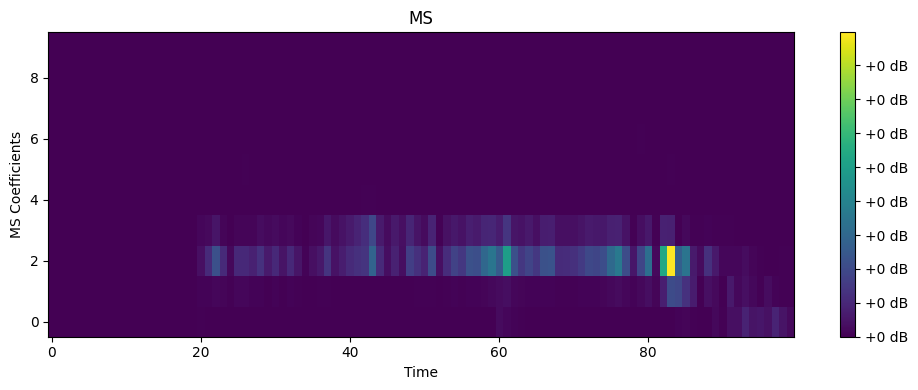

In [11]:
import matplotlib.pyplot as plt

# Lấy dữ liệu âm thanh từ df_0 hoặc df_1 (ví dụ với df_0)
data = df_0["0_0.wav"]  # Thay đổi chỉ số 0 nếu bạn muốn hiển thị dữ liệu khác
# Tính toán MFCC
mfcc = convert_melspectrogram(data)

# Hiển thị biểu đồ MFCC
plt.figure(figsize=(10, 4))
plt.imshow(mfcc, aspect='auto', origin='lower', cmap='viridis')
plt.title('MS')
plt.xlabel('Time')
plt.ylabel('MS Coefficients')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

In [14]:
x = []
y = []
b, a = signal.butter(3, [80/44100, 1200/44100], analog=False, btype='band', output='ba')
# Xử lý dữ liệu từ df_0
for i in df_0:
    data = convert_melspectrogram(df_0[i])
    x.append(data.reshape(10, data.shape[1], 1))  # Đảm bảo reshaping cho đúng với kích thước MFCC
    y.append([0, 1])

# Xử lý dữ liệu từ df_1
for i in df_1:
    data = convert_melspectrogram(df_1[i])
    x.append(data.reshape(10, data.shape[1], 1))  # Tương tự cho df_1
    y.append([1, 0])

In [15]:
from keras.models import Sequential
from keras.layers import Conv2D,Conv1D
from keras.layers import MaxPooling2D,MaxPooling1D
from keras.layers import Dense
from keras.layers import Flatten, Activation
from keras.layers import Dropout, LSTM,Reshape, InputLayer
from keras.layers import BatchNormalization,Bidirectional, Activation,TimeDistributed,ReLU
from keras.layers import GRU
from keras.optimizers import Adam

In [16]:
from sklearn.model_selection import train_test_split
x_train, x_, y_train, y_ = train_test_split(x, y, test_size=0.4, random_state=42)
x_test,x_val,y_test,y_val = train_test_split(x_,y_,test_size=0.5,random_state=42)
x_train = np.array(x_train)
x_test = np.array(x_test)
x_val = np.array(x_val)
y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

In [ ]:
np.shape(x_train)

(600, 10, 100, 1)

In [17]:
model = Sequential()
model.add(tf.keras.layers.Input(shape=(10,100,1)))
model.add(Conv2D(64, (3,6), activation='relu'))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(Conv2D(16, (2,2), activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPooling2D((2,4)))
model.add(Conv2D(16, (2,6), activation='relu'))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='sigmoid'))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 8, 95, 64)      │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 6, 93, 32)      │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 5, 92, 16)      │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 92, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 2, 23, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 1, 18, 16)      │         3,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,146 (133.38 KB)

 Trainable params: 34,146 (133.38 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
model.compile(loss = 'BinaryCrossentropy',
             optimizer = Adam(learning_rate = 0.0001),
             metrics = ['accuracy'])
model.trainable = True
history = model.fit(x_train,y_train ,batch_size = 10, epochs = 50,validation_data=(x_val,y_val))

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5265 - loss: 0.6857 - val_accuracy: 0.4600 - val_loss: 0.6720
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6299 - loss: 0.6332 - val_accuracy: 0.5250 - val_loss: 0.6411
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6353 - loss: 0.6098 - val_accuracy: 0.5700 - val_loss: 0.6320
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6411 - loss: 0.6035 - val_accuracy: 0.5900 - val_loss: 0.6194
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6322 - loss: 0.5832 - val_accuracy: 0.6800 - val_loss: 0.5939
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6877 - loss: 0.5671 - val_accuracy: 0.7150 - val_loss: 0.5694
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7183 - loss: 0.5405 - val_accuracy: 0.7300 - val_loss: 0.5511
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7507 - loss: 0.5218 - val_accuracy: 0.7250 - val_loss:

In [ ]:
model.save("model_final_mfcc.keras")
# model = tf.keras.models.load_model('model_final.hb',custom_objects = {"Keraslayers": hub.KerasLayer})
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 8, 95, 64)      │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 6, 93, 32)      │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 5, 92, 16)      │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 5, 92, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 23, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 1, 18, 16)      │         3,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,440 (400.16 KB)

 Trainable params: 34,146 (133.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 68,294 (266.78 KB)

In [19]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print("Test Accuracy:", test_accuracy, '\nLoss: 0.0962', )

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8667 - loss: 0.3674  
Test Accuracy: 0.875 
Loss: 0.0962


In [ ]:
y_pre = model.predict(x_val)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


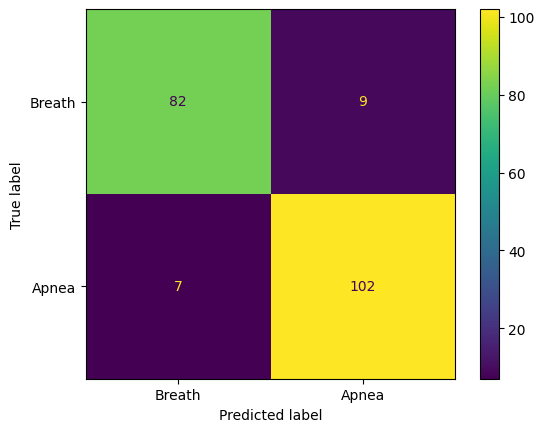

In [ ]:
cm = confusion_matrix(np.argmax(y_val,axis = 1) , np.argmax(y_pre,axis = 1))
# Hiển thị ma trận nhầm lẫn với nhãn tùy chỉnh
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Breath", "Apnea"])
disp.plot()
plt.show()

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
def representative_dataset_generator():
    for i in range(50):
        yield [x_train[i:i+20].astype(np.float32)]  # Chuyển đổi kiểu dữ liệu và trả về một mẫu
converter.representative_dataset = representative_dataset_generator
#converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.float32
converter.inference_output_type = tf.float32
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]
converter.target_spec.supported_ops.append(tf.lite.OpsSet.SELECT_TF_OPS)
tflite_model = converter.convert()
open("model_final_mfcc.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Admin\AppData\Local\Temp\tmpdz3uhbd6\assets


INFO:tensorflow:Assets written to: C:\Users\Admin\AppData\Local\Temp\tmpdz3uhbd6\assets


Saved artifact at 'C:\Users\Admin\AppData\Local\Temp\tmpdz3uhbd6'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 10, 100, 1), dtype=tf.float32, name='keras_tensor_112')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  2660560433952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2660560434128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2660260531536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2660260534528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2660260536992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2660260539280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2660261892288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2660261894576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2660261896864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2660261901088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  26

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tensorflow\lite\python\convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


43592

In [ ]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="./model_final_mfcc.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input shape:", input_details[0]['shape'])
print("Input type:", input_details[0]['dtype'])

input_shape = input_details[0]['shape']

def tiny_predict(x_test, y_test):
    x_test = np.array(x_test, dtype=np.float32)
    count = 0
    for i in range(len(x_test)-1):
        interpreter.set_tensor(input_details[0]['index'],x_test[i:i+1])
        interpreter.invoke()
        result = interpreter.get_tensor(output_details[0]['index'])
        if np.argmax(y_test[i]) == np.argmax(result):
            count +=1
    return (count/len(x_test)*100)
print('Train accuracy (TinyML): ', tiny_predict(x_train, y_train),'%')
print('Test accuracy (TinyML): ', tiny_predict(x_val, y_val),'%')

Input shape: [  1  10 100   1]
Input type: <class 'numpy.float32'>
Train accuracy (TinyML):  98.66666666666667 %
Test accuracy (TinyML):  90.0 %
